# Interactive Facial Pose Analysis Pipeline

This notebook provides an interactive walk-through of the facial pose processing pipeline.
It connects the modular functions in pose_pipeline.py and utils/ into a reproducible workflow:

- Load and preprocess raw OpenPose landmark CSVs
- Mask low-confidence landmarks, interpolate gaps, apply filtering
- Normalize to screen coordinates and generate templates
- Run Procrustes alignment (global + participant) or analyze unaligned features
- Extract features and compute windowed metrics
- Explore results with interactive plots and statistical comparisons

**Requirements:** OpenPose CSV files with format `<participantID>_<condition>.csv`

In [2]:
%pip install -q matplotlib numpy pandas scipy tqdm seaborn ipywidgets ipympl
%matplotlib inline

import sys
from pathlib import Path

# Ensure repo root (with utils/ and pose_pipeline.py) is importable
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from pose_pipeline import run_pipeline, Config
from utils.nb_utils import outputs_exist, pick_norm_file, slice_first_seconds, \
                           candidate_metric_cols, default_metric, ensure_condition_order, bar_by_condition
from utils.viz_utils import create_interactive_pose_timeseries_viewer, procrustes_transform_series
from utils.normalize_utils import interocular_series

Note: you may need to restart the kernel to use updated packages.


## 1. Data Loading

Load raw OpenPose CSVs and filter to the subset of facial landmarks we care about.
The Config object (CFG) defines paths for raw and processed data.
If per-frame features already exist, the pipeline will skip re-computing them and only run linear metrics.

In [3]:

CFG = Config()
CFG.RAW_DIR  = "data/raw_examples/"
CFG.OUT_BASE = "data/processed/"

print("Config:")
print(" RAW_DIR :", CFG.RAW_DIR)
print(" OUT_BASE:", CFG.OUT_BASE)

import pose_pipeline as pp
pp.CFG = CFG  # push paths in

status = outputs_exist(CFG.OUT_BASE)
print("Found per-frame files:")
for k, v in status["per_frame"].items():
    print(f"  {k:>22}: {len(v)} file(s)")
print("Found linear files:")
for k, v in status["linear"].items():
    print(f"  {k:>22}: {v}")

# Default flags
pp.RUN_FILTER = pp.RUN_MASK = pp.RUN_INTERP_FILTER = pp.RUN_NORM = True
pp.RUN_TEMPLATES = True
pp.RUN_FEATURES_PROCRUSTES_GLOBAL = True
pp.RUN_FEATURES_PROCRUSTES_PARTICIPANT = True
pp.RUN_FEATURES_ORIGINAL = True
pp.RUN_LINEAR = True

# If per-frame already exist -> linear only
if status["any_per_frame"]:
    pp.RUN_FILTER = pp.RUN_MASK = pp.RUN_INTERP_FILTER = pp.RUN_NORM = False
    pp.RUN_TEMPLATES = pp.RUN_FEATURES_PROCRUSTES_GLOBAL = False
    pp.RUN_FEATURES_PROCRUSTES_PARTICIPANT = False
    pp.RUN_FEATURES_ORIGINAL = False
    pp.RUN_LINEAR = True
    print("\nMode: Reuse per-frame features → compute linear metrics only.")
else:
    print("\nMode: Full run (steps 1–7) + linear metrics (step 8).")

pp.OVERWRITE = True
pp.OVERWRITE_TEMPLATES = False

pp.run_pipeline()


Config:
 RAW_DIR : data/raw_examples/
 OUT_BASE: data/processed/
Found per-frame files:
       procrustes_global: 145 file(s)
  procrustes_participant: 145 file(s)
                original: 145 file(s)
Found linear files:
       procrustes_global: True
  procrustes_participant: True
                original: True

Mode: Reuse per-frame features → compute linear metrics only.
[OK] Wrote data/processed/linear_metrics/procrustes_global_linear.csv
[OK] Wrote data/processed/linear_metrics/procrustes_participant_linear.csv
[OK] Wrote data/processed/linear_metrics/original_linear.csv


## 2. Procrustes (Global Template)

Compute features after aligning each frame to a global template (averaged across participants).
This removes inter-participant variability and highlights within-participant deviations.
Interactive viewer shows:
- Landmark trajectories
- Blink distance
- Mouth opening
- Head rotation

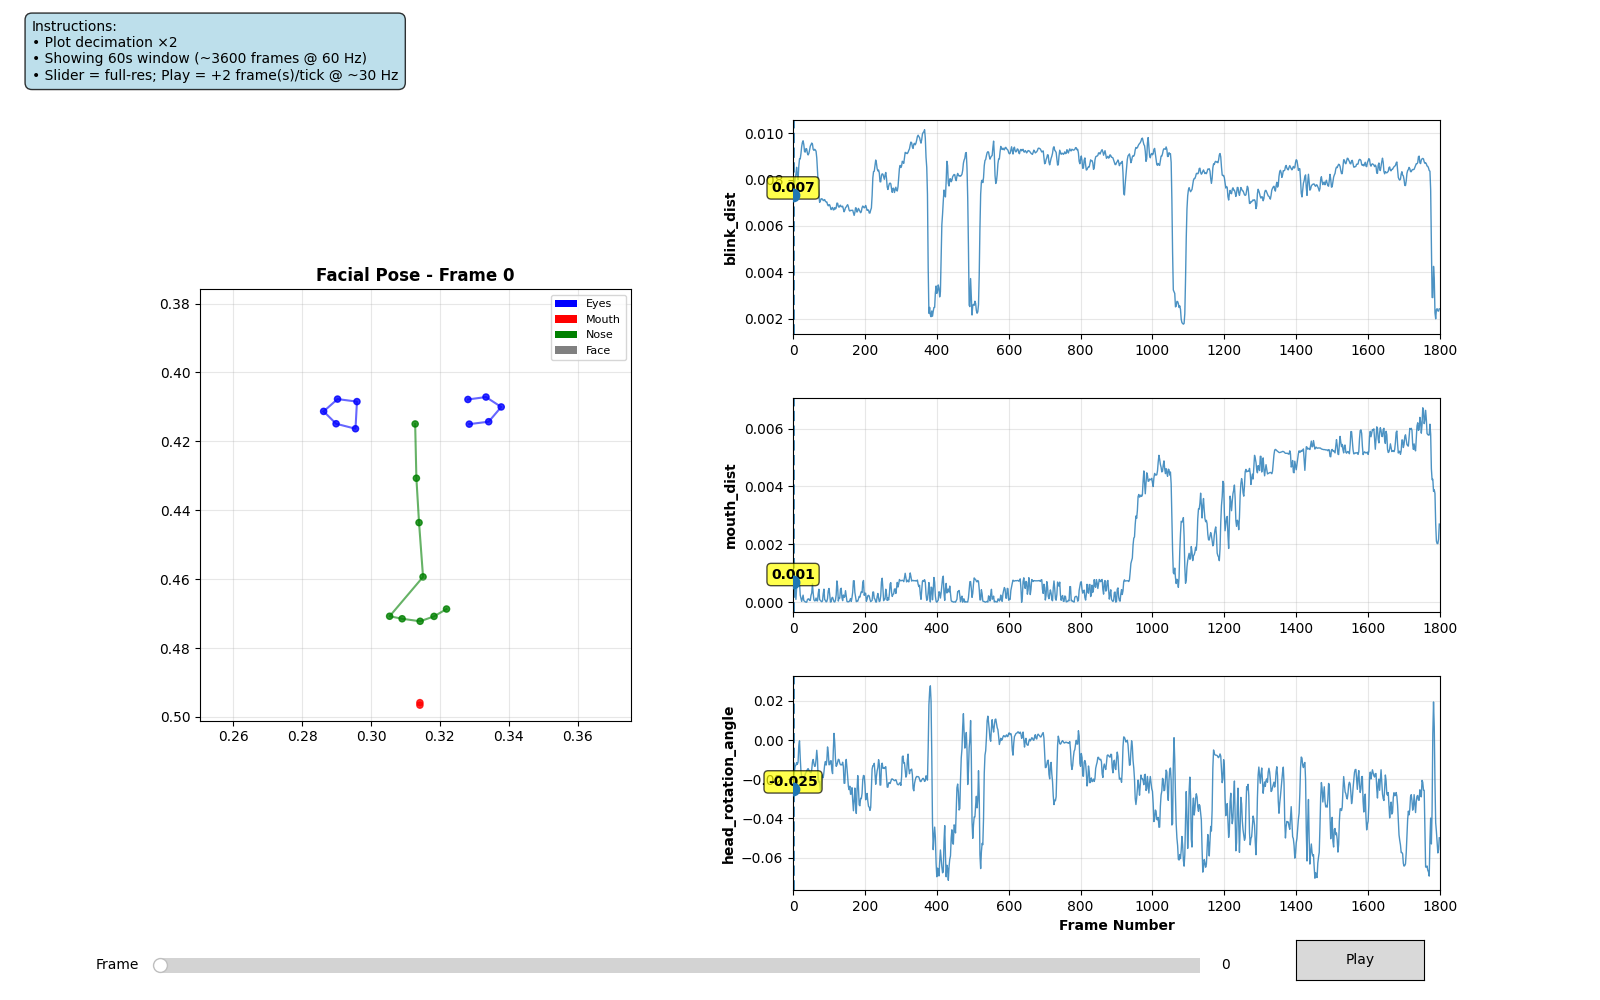

In [3]:
%matplotlib widget
import pandas as pd

OUT_BASE = CFG.OUT_BASE
FPS = CFG.FPS

# pick a normalized CSV and slice to 60s
norm_path = pick_norm_file(OUT_BASE)
df_norm_full = pd.read_csv(norm_path)
df_norm_60 = slice_first_seconds(df_norm_full, FPS, 60)

# load global template
templ_path = Path(OUT_BASE) / "templates" / "global_template.csv"
templ_df = pd.read_csv(templ_path)

# build aligned pose + basic per-frame features for viewer
df_pose_glob, feats_glob = procrustes_transform_series(df_norm_60, templ_df)
df_feats_glob = pd.DataFrame(feats_glob)

fig_glob = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose_glob,
    df_features=df_feats_glob,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=FPS,
    plot_downsample=2,
    window_seconds=60
)


## 3. Procrustes (Participant Template)

Align each participant’s frames to their own template.
This reduces bias from global template mismatch and helps when faces differ in scale/shape.
Same viewer tools as above, but per-participant baseline.

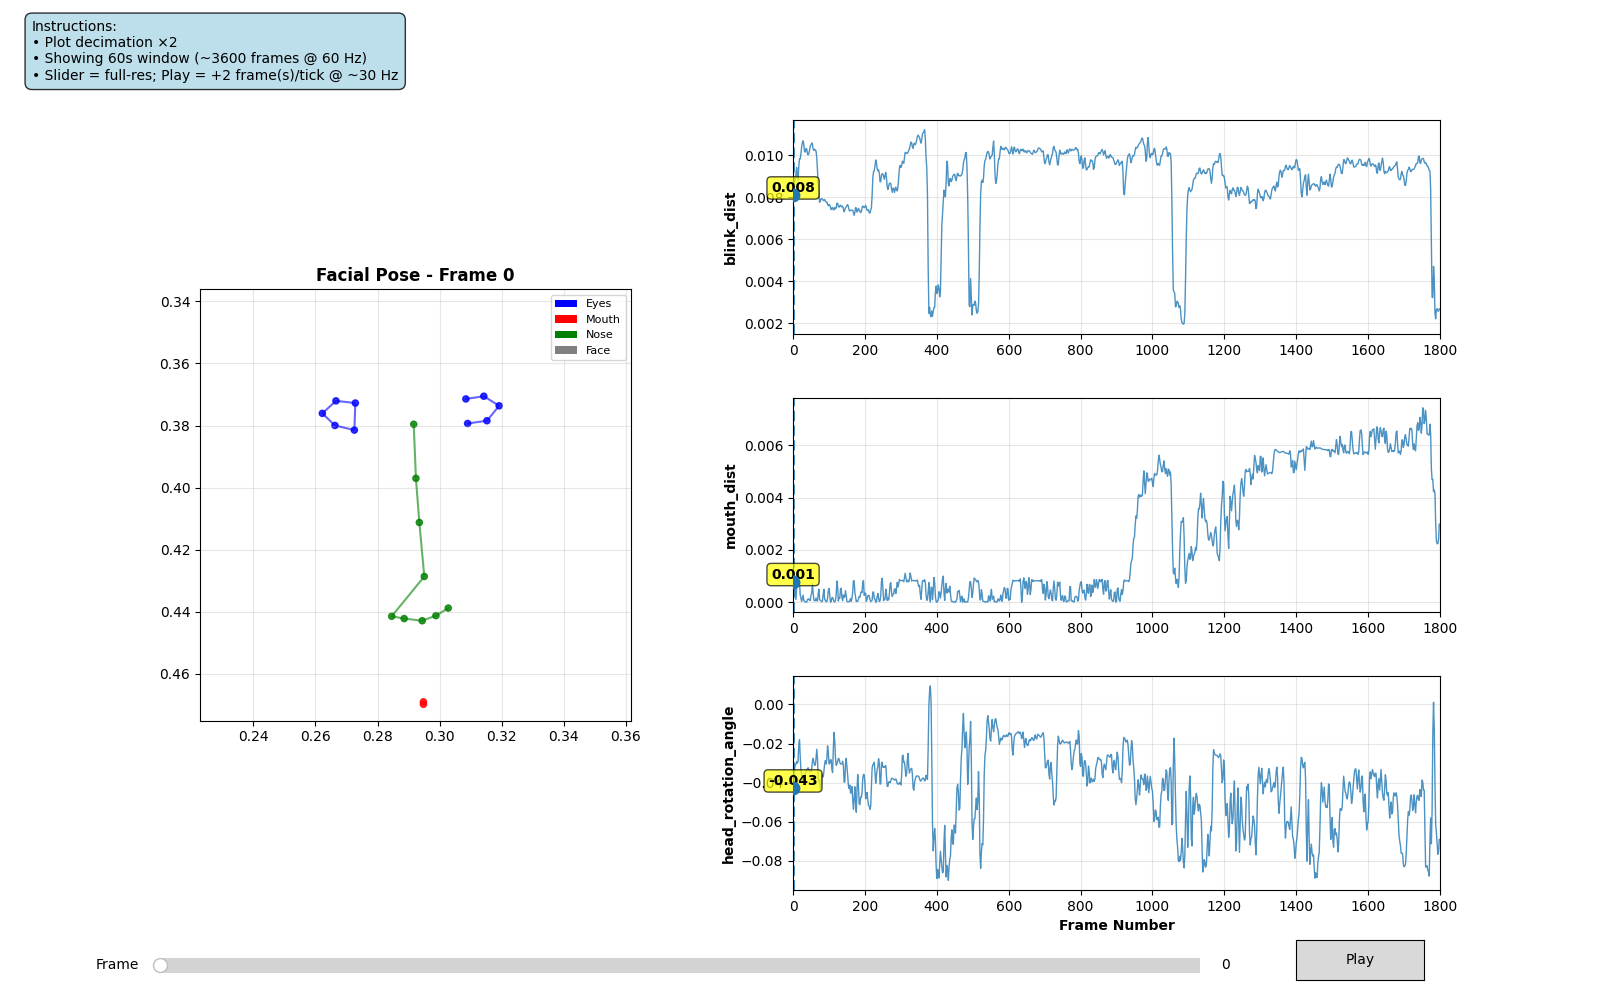

In [4]:
%matplotlib widget
import re
import pandas as pd

def parse_pid_cond(p: Path) -> tuple[str,str]:
    m = re.match(r"^([A-Za-z0-9]+)_([A-Za-z0-9]+)", p.stem)
    return (m.group(1), m.group(2)) if m else ("NA","NA")

norm_path = pick_norm_file(CFG.OUT_BASE)
pid, cond = parse_pid_cond(Path(norm_path))
df_norm_full = pd.read_csv(norm_path)
df_norm_60 = slice_first_seconds(df_norm_full, CFG.FPS, 60)

part_templ_path = Path(CFG.OUT_BASE) / "templates" / f"participant_{pid}_template.csv"
templ_df = pd.read_csv(part_templ_path)

df_pose_part, feats_part = procrustes_transform_series(df_norm_60, templ_df)
df_feats_part = pd.DataFrame(feats_part)

fig_part = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose_part,
    df_features=df_feats_part,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=CFG.FPS,
    plot_downsample=2,
    window_seconds=60
)


## 4. Original (Unaligned)

Extract blink, mouth, and head features without alignment. 

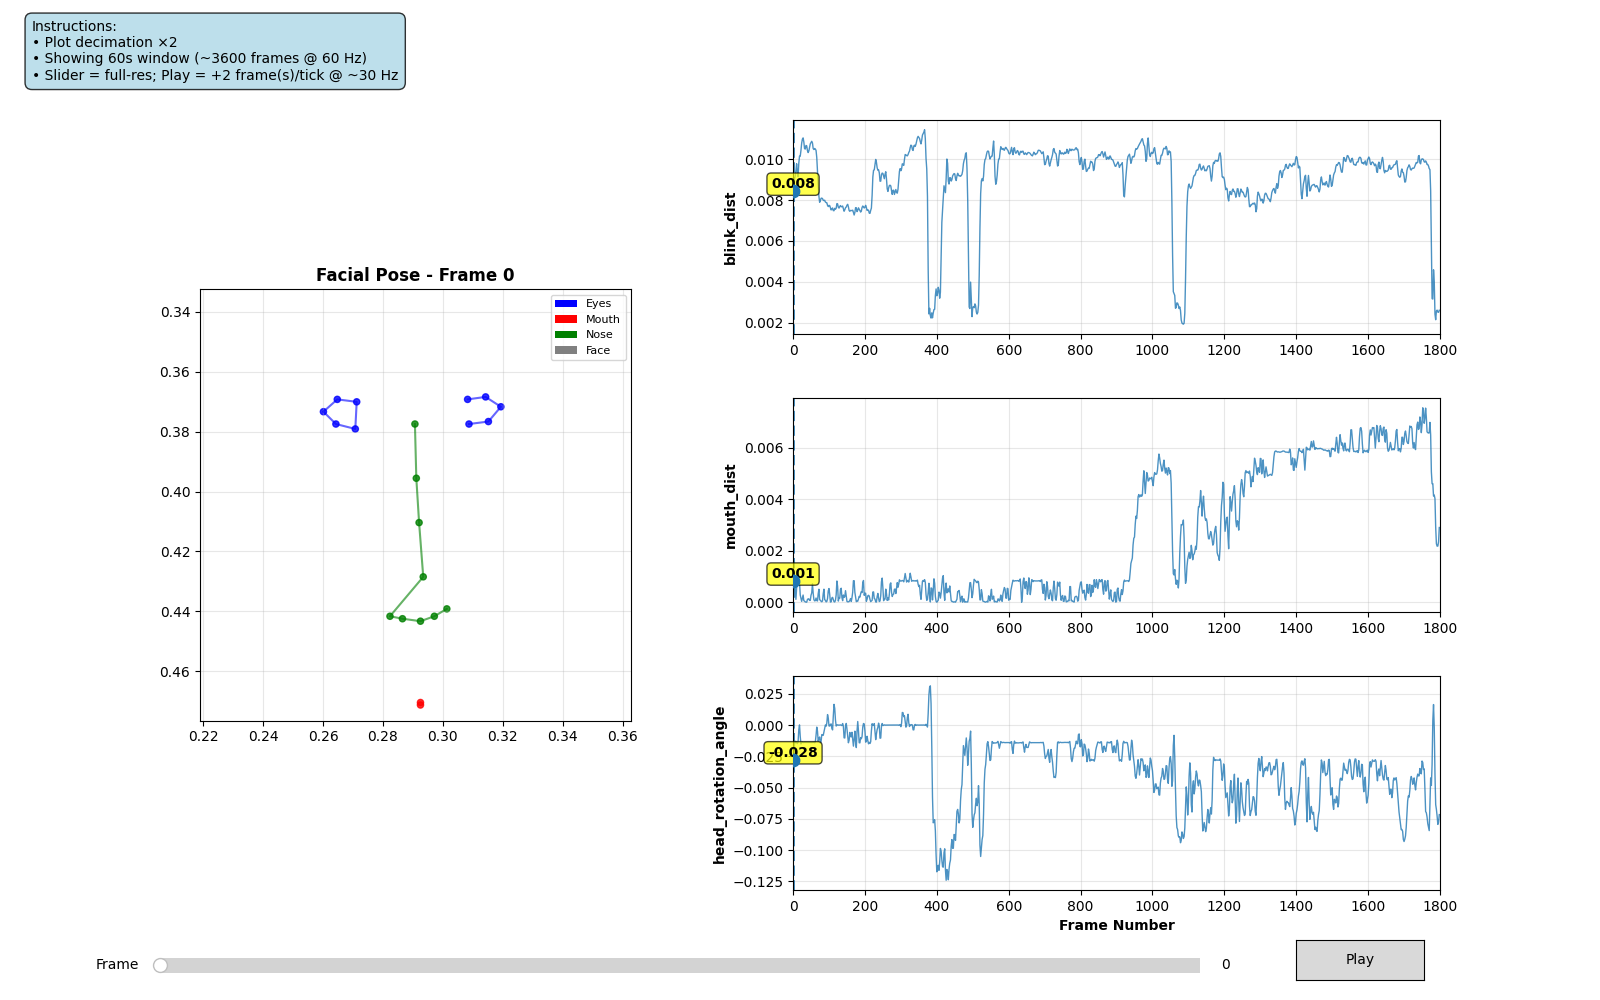

In [5]:
%matplotlib widget
import pandas as pd
import numpy as np
from utils.nb_utils import series_num

norm_path = pick_norm_file(CFG.OUT_BASE)
df_pose = slice_first_seconds(pd.read_csv(norm_path), CFG.FPS, 60)

n = len(df_pose)
dx = (series_num(df_pose,"x",46,n) - series_num(df_pose,"x",37,n)).to_numpy(float)
dy = (series_num(df_pose,"y",46,n) - series_num(df_pose,"y",37,n)).to_numpy(float)
head_rotation_angle = np.arctan2(dy, dx)

def _avg2(a,b): return (a+b)/2.0
Ltop = _avg2(series_num(df_pose,"y",38,n), series_num(df_pose,"y",39,n))
Lbot = _avg2(series_num(df_pose,"y",41,n), series_num(df_pose,"y",42,n))
Rtop = _avg2(series_num(df_pose,"y",44,n), series_num(df_pose,"y",45,n))
Rbot = _avg2(series_num(df_pose,"y",47,n), series_num(df_pose,"y",48,n))
blink_L = (Ltop - Lbot).abs().to_numpy(float)
blink_R = (Rtop - Rbot).abs().to_numpy(float)
blink_dist = np.where(np.isfinite(blink_L) & np.isfinite(blink_R),
                      (blink_L + blink_R)/2.0,
                      np.where(np.isfinite(blink_L), blink_L,
                               np.where(np.isfinite(blink_R), blink_R, np.nan)))
x63 = series_num(df_pose,"x",63,n).to_numpy(float); y63 = series_num(df_pose,"y",63,n).to_numpy(float)
x67 = series_num(df_pose,"x",67,n).to_numpy(float); y67 = series_num(df_pose,"y",67,n).to_numpy(float)
mouth_dist = np.sqrt((x67-x63)**2 + (y67-y63)**2)

df_feats_orig = pd.DataFrame({
    "head_rotation_angle": head_rotation_angle,
    "blink_dist": blink_dist,
    "mouth_dist": mouth_dist,
})

fig_orig = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose,
    df_features=df_feats_orig,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=CFG.FPS,
    plot_downsample=2,
    window_seconds=60
)


## 5. Linear Metrics Analysis

Aggregate windowed metrics (velocity, acceleration, RMS) across conditions.
Interactive widget:
- Choose normalization (Original / Global / Participant)
- Pick metric (auto-detected from CSV)
- Select test type (parametric / nonparametric)

Outputs:
- Condition-wise bar charts
- Descriptive stats (mean, std, median, SEM)
- Omnibus + pairwise group tests (Holm–Bonferroni corrected)

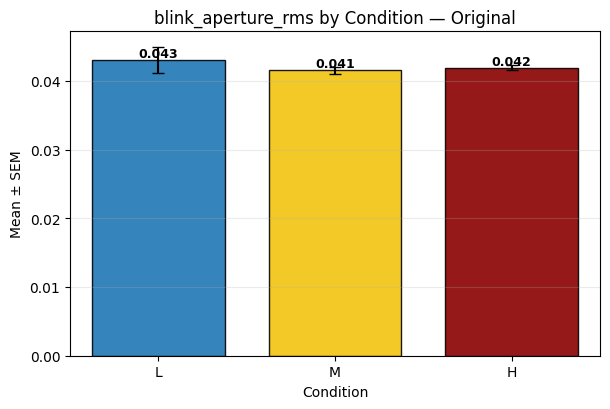

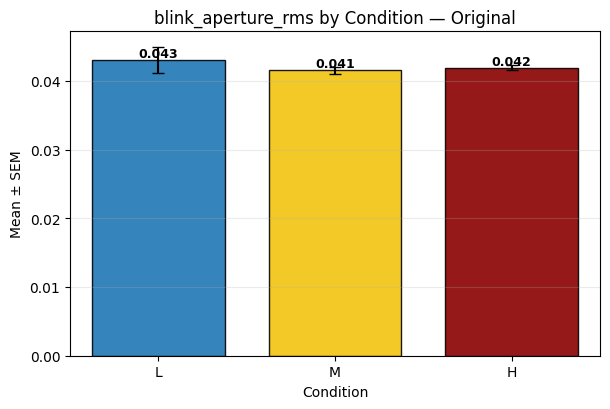

In [5]:
%matplotlib inline
import os
from pathlib import Path
import pandas as pd
from ipywidgets import ToggleButtons, Dropdown, VBox, HBox, Output
from IPython.display import display

from utils.nb_utils import (
    candidate_metric_cols, default_metric, ensure_condition_order, bar_by_condition
)
from utils.stats_utils import compare_groups_statistical  # new util

LIN_BASE = str(Path(CFG.OUT_BASE) / "linear_metrics")
CSV_MAP = {
    "Original":                   os.path.join(LIN_BASE, "original_linear.csv"),
    "Procrustes (Global)":        os.path.join(LIN_BASE, "procrustes_global_linear.csv"),
    "Procrustes (Participant)":   os.path.join(LIN_BASE, "procrustes_participant_linear.csv"),
}

def load_linear_df(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing file: {csv_path}")
    return ensure_condition_order(pd.read_csv(csv_path))

# ---- widgets ----
w_norm  = ToggleButtons(options=list(CSV_MAP.keys()), value="Original", description="Normalization:")
w_metric = Dropdown(options=[], description="Metric:")
w_test  = ToggleButtons(options=["auto", "parametric", "nonparametric"], value="auto", description="Test:")
out_plot = Output()
out_stats = Output()

def refresh(norm_label):
    df = load_linear_df(CSV_MAP[norm_label])
    cols = candidate_metric_cols(df)
    w_metric.options = cols
    if cols and w_metric.value not in cols:
        w_metric.value = default_metric(cols)

def draw(*_):
    out_plot.clear_output(); out_stats.clear_output()
    df = load_linear_df(CSV_MAP[w_norm.value])
    if not w_metric.options or w_metric.value not in w_metric.options:
        refresh(w_norm.value)
    metric = w_metric.value
    if metric is None:
        with out_plot: print("No numeric metric found in file."); return

    # bar chart
    with out_plot:
        bar_by_condition(df, metric, title_suffix=w_norm.value)

    # stats
    res = compare_groups_statistical(df, metric, test_type=w_test.value)
    with out_stats:
        print(f"Omnibus: {res['omnibus']['name']}  stat={res['omnibus']['stat']:.4f}  p={res['omnibus']['p']:.4g}")
        print(f"Test type: {res['test_type']}\n")
        print("Descriptives (per condition):")
        display(res["descriptives"].style.format({"mean":"{:.4f}","std":"{:.4f}","sem":"{:.4f}","median":"{:.4f}"}))
        if not res["pairwise"].empty:
            print("\nPairwise (Holm–Bonferroni corrected):")
            display(res["pairwise"].style.format({"p_raw":"{:.4g}","p_holm":"{:.4g}"}))
        else:
            print("\nPairwise: (k<=2 or not applicable)")

# wire events
w_norm.observe(lambda ch: (ch["name"]=="value") and (refresh(ch["new"]) or draw()))
w_metric.observe(lambda ch: (ch["name"]=="value") and draw())
w_test.observe(lambda ch: (ch["name"]=="value") and draw())

# init
refresh(w_norm.value); draw()
display(VBox([HBox([w_norm, w_metric, w_test]), out_plot, out_stats]))
